# Rotterdam stylized case
#### last updated 16/3/2020

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Step 1: calculate one possible realisation of actual storm surge levels at Rotterdam, for 4 different scenarios of SLR 
Each time you run you get another possible realisation of storm surge levels

Text(0, 0.5, 'Storm surge height (m)')

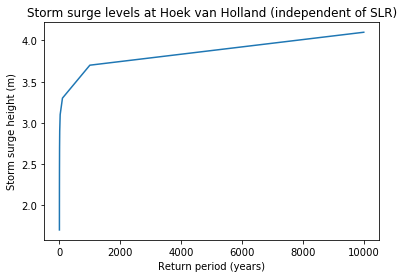

In [5]:
#STORM SURGE LEVELS AT HOEK VAN HOLLAND (ASSUMED TO BE INDEPENDENT OF SEA LEVEL RISE)
#Very roughly taken from Sterl et al. (2009)
RP = [1/5,  1/2,1 ,  2,  5,10,25  ,100,1000,10000]
surge = [1.7,2  ,2.2 ,2.4,2.7,2.9,3.1,3.3,3.7 ,4.1]
plt.plot(RP,surge)
plt.title('Storm surge levels at Hoek van Holland (independent of SLR)')
plt.xlabel('Return period (years)')
plt.ylabel('Storm surge height (m)')

In [6]:
np.interp(500,RP,surge)

3.477777777777778

In [7]:
#FLOOD PROTECTION LEVEL 2020
FPL = 1000

In [8]:
#FOR NOW: ASSUME THAT ONE STORM PER YEAR WILL OCCUR
startyear = 2021
endyear = 2120
#APPROXIMATION OF THE GUMEL PLOT OF Sterl et al. (2009) 
#An ensemble study of extreme storm surge related water levels in the North Sea in a changing climate
mu = 2.33
beta = 0.234
surges_t = np.random.gumbel(mu,beta,size=100) #calculates a storm surge level (m) for each year

In [9]:
#surges_t

In [10]:
#plt.hist(surges_t)

In [11]:
#CALCULATE STORM SURGE LEVELS BACK TO RETURN PERIODS
#np.interp(surges_t,surge,RP)

In [12]:
#SLR scenarios
year = [2000,2020,2050,2075,2100]
A =    [0,   0.1 , 0.2, 0.3, 0.4] #Haasnoot et al. 2020, lower part of blue shaded area
B =    [0,   0.1 ,0.25,0.45, 1.0] #Middle of RCP4.5
C =    [0,   0.1 , 0.3,0.7 , 1.8] #Middle of RCP8.5
D =    [0,   0.15, 0.4, 1.0 ,3.0] #Max of RCP8.5   

#determine coefficients of paraboles plotted through these functions
A_p = np.polyfit(year,A,2) #returns the coefficient of the paraboles (highest first)
B_p = np.polyfit(year,B,2)
C_p = np.polyfit(year,C,2)
D_p = np.polyfit(year,D,2)

time = np.arange(2021,2121) #create list from 2020 to 2120

#CREATE TIME SERIES FOR SEA LEVEL RISE (IMITATE THOSE IN HAASNOOT ET AL 2020)
A_t = [(lambda x: A_p[2]+A_p[1]*x+A_p[0]*x**2)(x) for x in time]
B_t = [(lambda x: B_p[2]+B_p[1]*x+B_p[0]*x**2)(x) for x in time]
C_t = [(lambda x: C_p[2]+C_p[1]*x+C_p[0]*x**2)(x) for x in time]
D_t = [(lambda x: D_p[2]+D_p[1]*x+D_p[0]*x**2)(x) for x in time]

In [13]:
#Sum the storm surge levels and the SLR scenarios
levels_A_t = surges_t+A_t
levels_B_t = surges_t+B_t
levels_C_t = surges_t+C_t
levels_D_t = surges_t+D_t

#CALCULATE THE RPS (what would be the return period of the future floods for statistics of the current situation)
RPs_A_t = np.interp(levels_A_t,surge,RP)
RPs_B_t = np.interp(levels_B_t,surge,RP)
RPs_C_t = np.interp(levels_C_t,surge,RP)
RPs_D_t = np.interp(levels_D_t,surge,RP)

Text(0.5, 1.0, 'Scenario D')

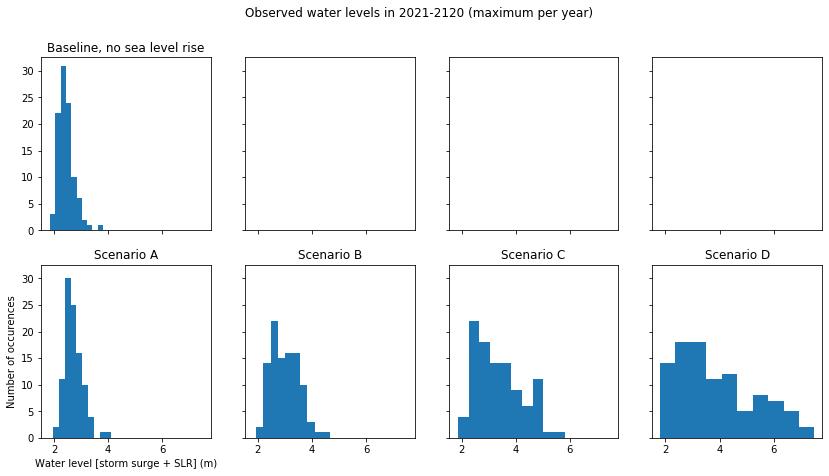

In [14]:
### PLOT THE HISTOGRAMS OF THE DIFFERENT RETURN PERIODS
figure, axes = plt.subplots(nrows=2,ncols=4,sharey=True,sharex=True,figsize=(14,7))
axes[0,0].hist(surges_t)
axes[1,0].hist(levels_A_t)
axes[1,1].hist(levels_B_t)
axes[1,2].hist(levels_C_t)
axes[1,3].hist(levels_D_t)
figure.suptitle('Observed water levels in 2021-2120 (maximum per year)')
axes[0,0].set_title('Baseline, no sea level rise')
axes[1,0].set_xlabel('Water level [storm surge + SLR] (m)')
axes[1,0].set_ylabel('Number of occurences')
axes[1,0].set_title('Scenario A')
axes[1,1].set_title('Scenario B')
axes[1,2].set_title('Scenario C')
axes[1,3].set_title('Scenario D')

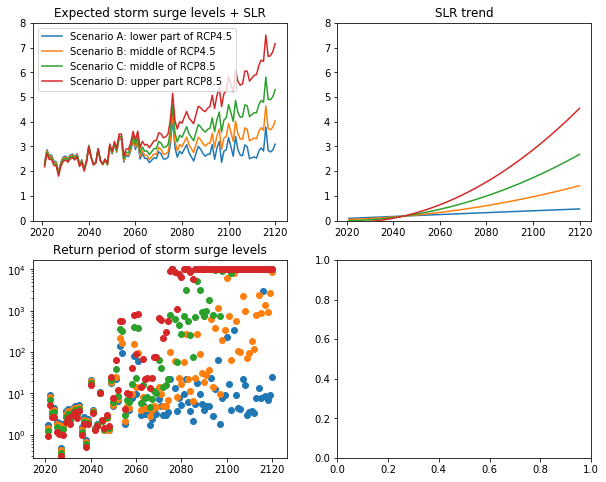

In [15]:
#Plot as a time series

fig, axes = plt.subplots(nrows=2,ncols=2,sharey=False,figsize=(10,8))
#fig = plt.figure()
axes[0,0].plot(time,levels_A_t,
             time,levels_B_t,
             time,levels_C_t,
             time,levels_D_t)
axes[0,0].legend(labels=[
    'Scenario A: lower part of RCP4.5',
    'Scenario B: middle of RCP4.5',   
    'Scenario C: middle of RCP8.5',   
    'Scenario D: upper part RCP8.5',
])
axes[0,0].set_title('Expected storm surge levels + SLR')
axes[0,1].set_title('SLR trend')
axes[1,0].set_title('Return period of storm surge levels')
axes[0,1].plot(time,A_t,time,B_t,time,C_t,time,D_t)

axes[0,0].set_ylim(0,8)
axes[0,1].set_ylim(0,8)

axes[1,0].scatter(time,RPs_A_t)
axes[1,0].scatter(time,RPs_B_t)
axes[1,0].scatter(time,RPs_C_t)
axes[1,0].scatter(time,RPs_D_t)
axes[1,0].set_yscale('log')

### Step 2: Storm surges have an impact on trust

In [16]:
# Public trust

# The trust ranges from 0 to 100%, with 100% begin good
# Normally, the trust is around 70 %

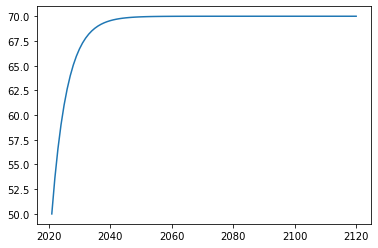

In [21]:
from scipy.integrate import odeint

def trust_model(T,t):
    k = 0.2 #coefficient for recovery of trust
    T_eq = 70
    dTdt = (T-T_eq)*-k
    return dTdt

T0 = 50
t = np.arange(2021,2121)
T = odeint(trust_model,T0,t)

plt.plot(t,T)

In [22]:
#RPs_A_t.astype(int)

In [23]:
high_water_threshold = 50 #Return period at which people are a little bit uncomfortable
near_miss_threshold = 1000 #Return period of the near-miss event in years
flood_threshold = 6000 #Return period of a flood

events = RPs_A_t

def calculate_trust(time,events):
    """Calculate the development of trust over time, for a series of events
    Input:
        *time* : List of year numbers
        *events* : time series of events
        
    Returns:
        *Trust* : development of trust over time (0-100% scale)
    
    """
    T_t = [None] * len(time)
    T_t[0] = 50 #initial trust condition
    for i,t in enumerate(time):
        if i != 0:
            #print("i = {}, t = {}".format(i,t))
            #print("RP = {}".format(RPs_A_t[i]))

            #If a near miss happens: trust goes down a lot
            if events[i] > flood_threshold:
                T_t[i] = T_t[i-1] - 30

            #If a near miss happens: trust goes down a bit
            elif events[i] > near_miss_threshold:
                T_t[i] = T_t[i-1] - 10
            
            #If a high water occurs, trust goes down a tiny bit
            elif events[i] > high_water_threshold:
                T_t[i] = T_t[i-1] - 2

            else:
                #If nothing happens: trust recovers to the equilibrium trust
                k = 0.2 #coefficient for recovery of trust
                T_eq = 70
                dTdt = (T_t[i-1]-T_eq)*-k
                T_t[i] = T_t[i-1] + dTdt

    return T_t

Text(0.5, 1.0, 'Development of public trust in the capalities of the government')

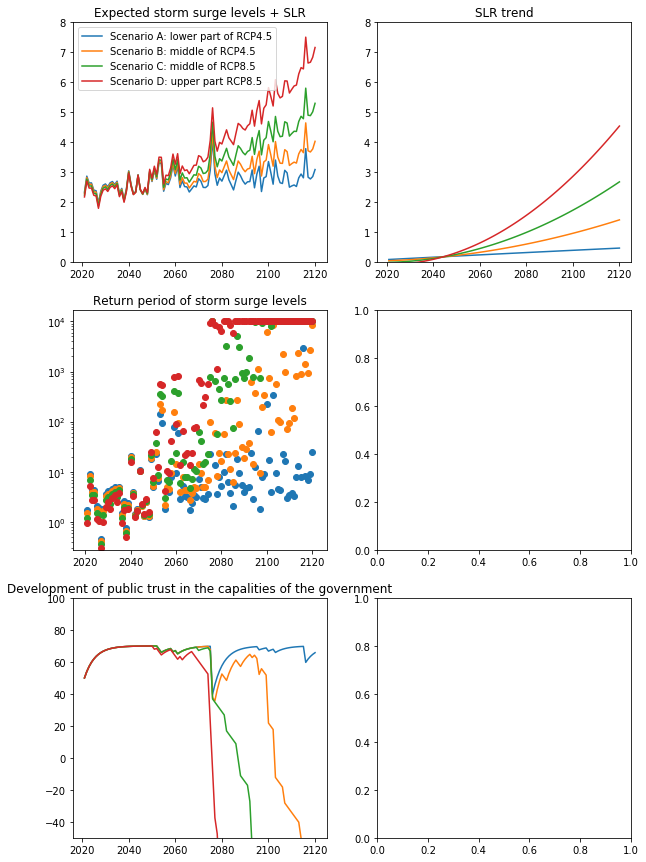

In [25]:
#Plot as a time series

fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,figsize=(10,15))
#fig = plt.figure()
axes[0,0].plot(time,levels_A_t,
             time,levels_B_t,
             time,levels_C_t,
             time,levels_D_t)
axes[0,0].legend(labels=[
    'Scenario A: lower part of RCP4.5',
    'Scenario B: middle of RCP4.5',   
    'Scenario C: middle of RCP8.5',   
    'Scenario D: upper part RCP8.5',
])
axes[0,0].set_title('Expected storm surge levels + SLR')
axes[0,1].set_title('SLR trend')
axes[1,0].set_title('Return period of storm surge levels')
axes[0,1].plot(time,A_t,time,B_t,time,C_t,time,D_t)

axes[0,0].set_ylim(0,8)
axes[0,1].set_ylim(0,8)

axes[1,0].scatter(time,RPs_A_t)
axes[1,0].scatter(time,RPs_B_t)
axes[1,0].scatter(time,RPs_C_t)
axes[1,0].scatter(time,RPs_D_t)
axes[1,0].set_yscale('log')

axes[2,0].plot(time,calculate_trust(time,RPs_A_t),
               time,calculate_trust(time,RPs_B_t),
               time,calculate_trust(time,RPs_C_t),
               time,calculate_trust(time,RPs_D_t))
axes[2,0].set_ylim(-50,100)
axes[2,0].set_title('Development of public trust in the capalities of the government')
